In [7]:
import os
import sys
import torch
import numpy as np
from torch import matmul as m
from matplotlib import pyplot as plt
from sdes import SDE,ConstantDiffusion,TwoDimensionalSynDrift,DoubleWellDrift
from torch.autograd.functional import jacobian

from torch.distributions import MultivariateNormal

sys.path.insert(0,".")

from utils import define_grid_ranges,define_mesh_points
from gps import MultivariateNormal,white_noise_kernel

# SDEs

In [6]:
# Define the drift and diffusion functions for the double well potential SDE
class DoubleWellDrift:
    def __init__(self, a=1.0, b=1.0):
        self.a = a
        self.b = b
    
    def __call__(self, x):
        x = -(self.a * x**3 - self.b * x)
        return x

class ConstantDiffusion:
    def __init__(self, sigma=0.5):
        self.sigma = sigma
    
    def __call__(self, x):
        return self.sigma * torch.ones_like(x)
    
class MaxDiffusion:
    def __init__(self, sigma=1.):
        self.sigma = sigma
    
    def __call__(self, x):
        D = self.sigma*torch.clamp(4. - 1.25*x**2,0.)
        return torch.sqrt(D)

In [12]:
dt = 0.002
number_of_steps = 5000
num_paths = 3
sigma = 1.

x_0 = torch.rand((1,)).unsqueeze(-1)
drift = DoubleWellDrift(a=4.,b=4.)
diffusion = MaxDiffusion()

#x_0 = torch.rand((2,)).unsqueeze(0)
#drift = TwoDimensionalSynDrift()
#diffusion = ConstantDiffusion()

sde = SDE(drift,diffusion,dt=dt)
paths = sde.simulate(x_0, number_of_steps, num_paths=num_paths)
dense_path_realization = paths[0,:,:]
dimensions = dense_path_realization.size(1)

num_dense_points = dense_path_realization.size(0)

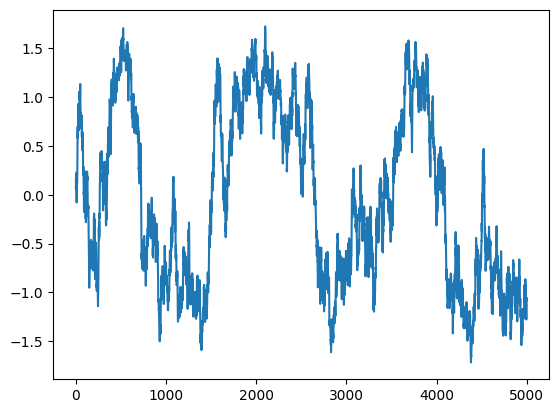

In [13]:
plt.plot(dense_path_realization.detach().numpy()[:,0])

In [ ]:
from utils import define_grid_ranges,define_mesh_points


In [11]:
dense_path_realization.shape

torch.Size([3001, 2])

In [12]:
num_evaluation_points = 2000
num_inducing_points = 500

ranges_ = define_grid_ranges(dense_path_realization)
evaluation_points = define_mesh_points(total_points = num_evaluation_points,n_dims = dimensions, ranges=ranges_)
inducing_points = define_mesh_points(total_points = num_inducing_points,n_dims = dimensions, ranges=ranges_)

In [412]:
#inducing_points = dense_path_realization

In [413]:
# path_realization dense representation of the path (only needed in dense observations)
# [num_dense_points,dimensions]

# ranges list len(ranges_) == dimension min and max values per dimension
# # evaluation_points [num_evaluation_points,dimensions] # WHERE TO EVALUATE THE FUNCTION
# inducing_points [num_inducing_points,dimensions] # WHERE TO EVALUATE THE SPARSE GP

# Sparse GPs approximation

In [414]:
from gps import white_noise_kernel
from gpytorch.kernels import RBFKernel, ScaleKernel
import numpy as np

In [415]:
kernel_sigma = 1.
kernel_l = .1

# ========================================================================
# DEFINE AND INITIALIZE KERNEL
kernel = ScaleKernel(RBFKernel(ard_num_dims=dimensions, requires_grad=True),requires_grad=True) + white_noise_kernel()
hypers = {"raw_outputscale": torch.tensor(kernel_sigma),
          "base_kernel.raw_lengthscale": torch.tensor(np.repeat(kernel_l, dimensions))}
kernel = kernel.kernels[0].initialize(**hypers)

In [420]:
y = (dense_path_realization[1:,:] - dense_path_realization[:-1,:])/dt
Diff = diffusion(dense_path_realization[1:,:])
real_drift = drift(evaluation_points)
j = 1
num_inducing_points = inducing_points.size(0)

y_j = y[:,j].unsqueeze(-1)
K_ns = kernel.forward(dense_path_realization[:-1,:], inducing_points)
K_xs = kernel.forward(evaluation_points, inducing_points)
K_ss = kernel.forward(inducing_points, inducing_points)
K_ss_inv = torch.inverse(K_ss)

D_j_inv = torch.diag(1./Diff[:,j])
pi_j = m(K_ns,K_ss_inv)
Omega_j = m(pi_j.T,m(D_j_inv,pi_j))*dt

In [421]:
A = torch.inverse(torch.eye(num_inducing_points) + m(Omega_j,K_ss_inv)) 
f_x = m(pi_j.T,m(D_j_inv,y_j))*dt
f_x = m(K_xs,m(A,f_x))

In [422]:
f_x.shape

torch.Size([2025, 1])

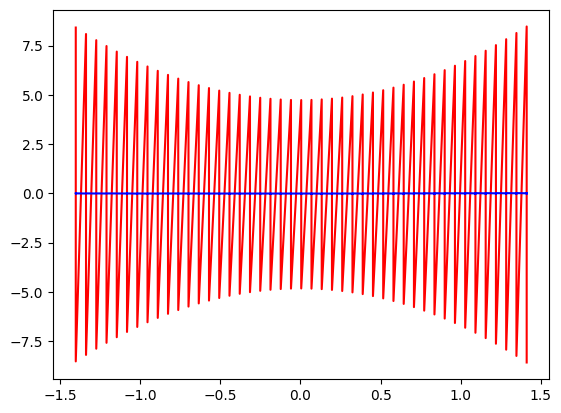

In [429]:
plt.plot(evaluation_points[:,0].detach().numpy(),real_drift[:,j],"r-")
plt.plot(evaluation_points[:,0].detach().numpy(),f_x.detach().numpy(),"b-")
plt.show()

In [430]:
sigma = 1.
gp_path = r"C:\Users\cesar\Desktop\Projects\DiffusiveGenerativeModelling\OurCodes\markov_bridges\data\raw\gps\2D.tr"
torch.save({"dense_path_realization":dense_path_realization,
            "sigma":sigma,
            "dt":dt},gp_path)

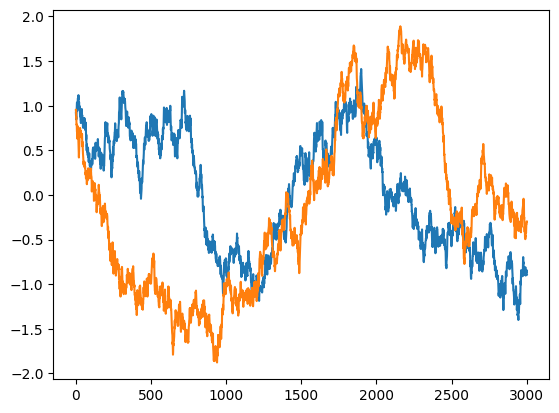

In [431]:
plt.plot(dense_path_realization)